<a href="https://colab.research.google.com/github/LuchoVidalSMN/RadarMeteo/blob/master/Read_and_plot_RVD_radar_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerías

In [1]:

!pip install --upgrade pip
!pip install fsspec>=2022.11.0
!pip install s3fs
!pip install pyproj
!pip install netCDF4
!pip install arm-pyart
!apt-get install -qq libgdal-dev libproj-dev
!pip install --force-reinstall --no-binary shapely shapely==1.7.0   #!pip install --no-binary shapely shapely --force
!pip install cartopy==0.21
!pip install glob2
!pip install --user urllib3==1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.4.0
    Uninstalling fsspec-2023.4.0:
      Successfully uninstalled fsspec-2023.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-

# Importacion de librerías

In [2]:

%reset_selective -f b
%matplotlib inline

import os
import gc
import io
import glob
import zlib
import pyart
import netCDF4
import matplotlib
import numpy as np
import scipy.io as sio
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

import cartopy
import cartopy.crs as ccrs
from pyproj import Proj

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#==============================================================================#

# Defino los limites de paises (descarga por unica vez)
provincias = cartopy.feature.NaturalEarthFeature(category='cultural',
                                                 name='admin_1_states_provinces_lines',
                                                 scale='10m',
                                                 facecolor='none')
   
paises = cartopy.feature.NaturalEarthFeature(category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none')

#==============================================================================#

# Lo que sigues es para montar Drive y poder leer archivos desde allí.
# RECOMENDACIÓN: crear una carpeta DATA en el home del Drive y alli poner los archivos a trabajar.
from google.colab import drive
drive.mount('/content/drive')

#==============================================================================#



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Mounted at /content/drive


# **Funcion read_rvd**
### **Nota:** *esta celda tiene que ejecutarse si o si antes de leer los datos.*

In [8]:

shift_az=7.5   #
shift_date = '20150420'

def rvd_read( input_file , radar_lon , radar_lat , radar_alt , correct_az = True , correct_elev = True ) :

   my_file = open(input_file,'rb')
   header_bufr=io.BytesIO( my_file.read(512*4) )
   data_bufr = my_file.read()
   my_file.close()

   range_res = 0.5  #Los datos de salida van a tener esta resolucion.
   max_nrange = 480  #Maxima cantidad de pixeles.

   #Get the data
   data = np.frombuffer( zlib.decompress( data_bufr , 16+zlib.MAX_WBITS ) , dtype=np.uint8)#/ 2 -32
   #Get the header
   header=dict()
   header['VERS']=np.array(header_bufr.readline()[6:]).astype(float)
   header['RADAR']=header_bufr.readline().decode('utf-8')[7:].rstrip(' \n')
   header['DATE']=header_bufr.readline().decode('utf-8')[6:].rstrip(' \n')

   header['MOMENT']=header_bufr.readline().decode('utf-8')[8:].rstrip(' \n')
   header['JOB_NAME']=header_bufr.readline().decode('utf-8')[10:].rstrip(' \n')
   header['NELEVS']=np.int(header_bufr.readline()[8:])
   header_bufr.readline()
   header['ELEVS']=np.zeros(header['NELEVS'])
   header['NRANGE']=np.zeros(header['NELEVS']).astype(int)
   header['RANGE_RES']=np.zeros(header['NELEVS'])
   header['NAZIMUTH']=np.zeros(header['NELEVS']).astype(int)
   header['V_MAX']=np.zeros(header['NELEVS'])
   for ielev in range( header['NELEVS']) :
      tmp_par = header_bufr.readline().decode('utf-8').rstrip('\n').split(':')
      #print(tmp_par)
      header['ELEVS'][ielev] = np.array( tmp_par[1] ).astype(float)
      header['NRANGE'][ielev] = np.array( tmp_par[2] ).astype(int)
      header['RANGE_RES'][ielev] = np.array( tmp_par[3] ).astype(float)
      header['NAZIMUTH'][ielev] = np.array( tmp_par[4] ).astype(int)
      header['V_MAX'][ielev] = np.array( tmp_par[5] ).astype(float)

   nazimuth = np.unique( header['NAZIMUTH'])
   if ( nazimuth.size > 1 ):
      print('Error: Tenemos diferentes numeros de azimuths!')

   # Make a empty radar with the dimensions of the dataset.
   radar = pyart.testing.make_empty_ppi_radar( max_nrange , nazimuth , header['NELEVS'])

   if correct_elev :
      if header['NELEVS']== 12 :
         header['ELEVS'] = np.array([0.3,0.5,0.9,1.3,1.8,2.3,3.1,4.0,5.1,6.3,8.0,10.0])
      elif header['NELEVS']== 14 :
         header['ELEVS'] = np.array([0.3,0.5,0.9,1.3,1.8,2.3,3.1,4.0,5.1,6.3,8.0,10.0,13.0,19.0])
      elif header['NELEVS']== 15 :
         header['ELEVS'] = np.array([0.4,0.9,1.3,1.7,2.2,2.8,3.5,4.4,5.5,6.8,8.4,10.3,13.4,19.2,34.3])
      else  :
         if header['ELEVS'][0] == header['ELEVS'][1] :
            header['ELEVS'][0]=0.3 

   # Start filling the radar attributes with variables in the dataset.

   radar.latitude['data']     = np.array([radar_lat])
   radar.longitude['data']    = np.array([radar_lon])
   radar.altitude['data']     = np.array([radar_alt])

   radar.range['data']        = range_res*np.arange(0,max_nrange)*1e3
   radar.fixed_angle['data']  = header['ELEVS']
   radar.sweep_number['data'] = header['NELEVS']

   radar.azimuth['data']=np.zeros( nazimuth * header['NELEVS'] )
   radar.elevation['data']=np.zeros( nazimuth * header['NELEVS'] )
   radar.time['data']=np.zeros( nazimuth * header['NELEVS'] )
   radar.ray_angle_res=dict()
   radar.ray_angle_res['data'] = 360.0 / nazimuth.astype(float)

   vel=np.nan * np.zeros((nazimuth[0]*header['NELEVS'],max_nrange))
   ref=np.nan * np.zeros((nazimuth[0]*header['NELEVS'],max_nrange))

   data_ =  np.nan * np.zeros((nazimuth[0]*header['NELEVS'],max_nrange))
   position=0
   ray=0

   for el in range(header['NELEVS']) :
      if  header['RANGE_RES'][el] == range_res    :
         my_range= int( min([ header['NRANGE'][el] , max_nrange ]) )
         for az in range(nazimuth[0]) :
            if header['MOMENT'] == 'Z'   :
               data_[ray,0:my_range]=data[ position:position+my_range ] / 2 -32
            if header['MOMENT'] == 'V'   :
               data_[ray,0:my_range]= ( data[ position:position+my_range ] - 255.0/2.0 ) * header['V_MAX'][el] / (255.0/2.0 )
            position = position + header['NRANGE'][el]
            radar.azimuth['data'][ray] = az * radar.ray_angle_res['data']
            radar.elevation['data'][ray] = radar.fixed_angle['data'][el]
            ray=ray+1
      if  header['RANGE_RES'][el] == range_res / 2.0   :
         my_range= int( min([ header['NRANGE'][el] , max_nrange * 2 ]) / 2 )
         for az in range(nazimuth[0]) :
           if header['MOMENT'] == 'Z'   :
               data_[ray,0:my_range]=running_mean(data[ position:position+ (my_range*2) ], 2)[::2] / 2 -32
           if header['MOMENT'] == 'V'   :
               data_[ray,0:my_range]= ( running_mean(data[ position:position+ (my_range*2) ], 2)[::2] - 255.0/2.0 ) * header['V_MAX'][el] / (255.0/2.0 )
            
           #ref[ray,0:my_range]=running_mean(data[ position:position+ (my_range*2) ], 2)[::2]
           position = position + header['NRANGE'][el]
           radar.azimuth['data'][ray] = az * radar.ray_angle_res['data']
           radar.elevation['data'][ray] = radar.fixed_angle['data'][el]
           ray=ray+1
            
            
   #Rotate azimuth for dates before shift_date 
   if correct_az :
      cdate = header['DATE']
      if float(cdate[0:8]) < float(shift_date)   :
         radar.azimuth['data'] = radar.azimuth['data'] + shift_az 

   # Let's work on the field data, we will just do reflectivity for now, but any of the
   # other fields can be done the same way and added as a key pair in the fields dict.
   if header['MOMENT'] == 'Z'  :
      ref_dict = pyart.config.get_metadata('reflectivity')
      ref_dict['data'] = np.array(data_)
      radar.fields = {'reflectivity': ref_dict}

   if header['MOMENT'] == 'V'  :
      ref_dict = pyart.config.get_metadata('velocity')
      ref_dict['data'] = np.array(data_)
      radar.fields = {'velocity': ref_dict}


   radar.metadata['instrument_name']='DWSR-2500C'
   
   radar.metadata['start_datetime']=cdate[0:4]+'-'+cdate[4:6]+'-'+cdate[6:8]+'T'+cdate[8:10]+':'+cdate[10:12]+':00Z'
   radar.metadata['start_time']=cdate[0:4]+'-'+cdate[4:6]+'-'+cdate[6:8]+' '+cdate[8:10]+':'+cdate[10:12]+':00.000'
   radar.metadata['end_datetime']=radar.metadata['start_datetime']
   radar.metadata['end_time']=radar.metadata['start_time']

   return radar


def order_variable ( radar , var_name , undef )  :

   import numpy as np
   import numpy.ma as ma

   #From azimuth , range -> azimuth , range , elevation

   if radar.ray_angle_res != None   :
      #print( radar.ray_angle_res , radar.ray_angle_res == None )
      ray_angle_res = np.unique( radar.ray_angle_res['data'] )
   else                             :
      print('Warning: ray_angle_res no esta definido, estimo la resolucion en radio como la diferencia entre los primeros angulos')
      ray_angle_res = np.min( np.abs( radar.azimuth['data'][1:] - radar.azimuth['data'][0:-1] ) )
      print('La resolucion en rango estimada es: ',ray_angle_res)


   if( np.size( ray_angle_res ) >= 2 )  :
      print('Warning: La resolucion en azimuth no es uniforme en los diferentes angulos de elevacion ')
      print('Warning: El codigo no esta preparado para considerar este caso y puede producir efectos indeseados ')
   ray_angle_res=np.nanmean( ray_angle_res )

   levels=np.sort( np.unique(radar.elevation['data']) )
   nb=radar.azimuth['data'].shape[0]

   order_azimuth=np.arange(0.0,360.0,ray_angle_res) #Asuming a regular azimuth grid

   na=np.size(order_azimuth)
   ne=np.size(levels)
   nr=np.size(radar.range['data'].data)


   var = np.ones( (nb,nr) )

   if ( var_name == 'altitude' ) :
       var[:]=radar.gate_altitude['data']
   elif( var_name == 'longitude' ) :
       var[:]=radar.gate_longitude['data']
   elif( var_name == 'latitude'  ) :
       var[:]=radar.gate_latitude['data']
   elif( var_name == 'x' )         :
       var[:]=radar.gate_x['data']
   elif( var_name == 'y' )         :
       var[:]=radar.gate_y['data']
   else  :
       var[:]=radar.fields[var_name]['data'].data


   #Allocate arrays
   order_var    =np.zeros((na,nr,ne))
   order_time   =np.zeros((na,ne))
   azimuth_exact=np.zeros((na,ne))
   order_n      =np.zeros((na,nr,ne),dtype='int')

   current_lev = radar.elevation['data'][0]
   ilev = np.where( levels == current_lev )[0]

   for iray in range( 0 , nb )  :   #Loop over all the rays

     #Check if we are in the same elevation.
     if  radar.elevation['data'][iray] != current_lev  :
         current_lev = radar.elevation['data'][iray]
         ilev=np.where( levels == current_lev  )[0]

     #Compute the corresponding azimuth index.
     az_index = np.round( radar.azimuth['data'][iray] / ray_angle_res ).astype(int)
     #Consider the case when azimuth is larger than na*ray_angle_res-(ray_angle_res/2)
     if az_index >= na   :
        az_index = 0

     tmp_var = var[iray,:]
     undef_mask = tmp_var == undef
     tmp_var[ undef_mask ] = 0.0

     order_var [ az_index , : , ilev ] = order_var [ az_index , : , ilev ] + tmp_var
     order_n   [ az_index , : , ilev ] = order_n   [ az_index , : , ilev ] + np.logical_not(undef_mask).astype(int)

     order_time[ az_index , ilev ] = order_time[ az_index , ilev ] + radar.time['data'][iray]
     azimuth_exact[ az_index , ilev ] = azimuth_exact[ az_index , ilev ] + radar.azimuth['data'][ iray ]

   order_var[ order_n > 0 ] = order_var[ order_n > 0 ] / order_n[ order_n > 0 ]
   order_var[ order_n == 0] = undef

   return order_var , order_azimuth , levels , order_time , azimuth_exact

def running_mean(x, N):
    tmp=np.zeros(np.shape(x))
    cumsum = np.cumsum(np.insert(x, 0, 0))
    tmp[0:-1]=(cumsum[N:] - cumsum[:-N]) / float(N)
    tmp[-1]=tmp[-2]
    return tmp


# Lectura archivo ejemplo

In [9]:

# Definicimos la ruta donde estan los datos (cambiar)
path_data = './'
FileList = np.sort(glob.glob(path_data+'*240*.rvd'))

# Archivo a leer
file2read = FileList[0]
print(file2read.split('/')[-1])

# Creamos archivo de configuración (no cambiar)
conf=dict()
conf['latradar'] = -34.787778
conf['lonradar'] = -58.536667
conf['altradar'] = 30.0

# Nombre del radar
nombre = 'SMN-Ezeiza'

# Hacemos la lectura y generamos el objeto "radar"
radar = rvd_read( file2read , conf['lonradar'] , conf['latradar'] , conf['altradar'] )


ar1.cz240p1.20121206.2000.z.rvd


<ipython-input-8-6114a3053d9f>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  header['NELEVS']=np.int(header_bufr.readline()[8:])


In [76]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (5040,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (5040,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float64 and shape: (5040, 480)>
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Reflectivity
		coordinates: elevation azimuth range
fixed_angle:
	data: <ndarray of type: float64 and shape: (14,)>
	long_name: Target angle for sweep
	units: d

# Figura de ejemplo

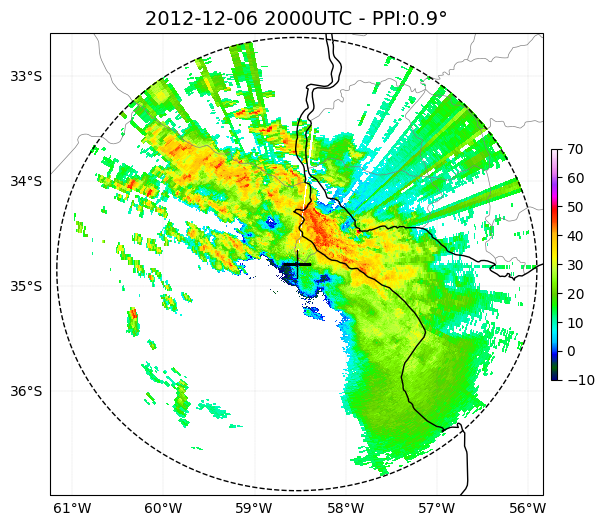

In [75]:

#==============================================================================#

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
rmax=240 # >>> Este rango maximo se usa luego para "recortar" los datos y graficar

lat_rmax = np.array([])
lon_rmax = np.array([])

for line in alfa:
  tmp1 = radar.latitude['data'] + (rmax/mm)*np.sin(line)
  tmp2 = radar.longitude['data'] + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)
gc.collect()

#==============================================================================#

# Extraemos datos a graficar de acuerdo al PPI definido por 'sweep'
sweep=2
start_index = radar.sweep_start_ray_index['data'][sweep]
end_index   = radar.sweep_end_ray_index['data'][sweep]
lats_rad    = radar.gate_latitude['data'][start_index:end_index]
lons_rad    = radar.gate_longitude['data'][start_index:end_index]
ref         = radar.fields['reflectivity']['data'][start_index:end_index, :]
ref[ref==-32.0] = np.nan

#==============================================================================#

# Definimos proyeccion
projection = ccrs.PlateCarree()
extent = [
          radar.longitude['data']-2.7,
          radar.longitude['data']+2.7,
          radar.latitude['data']-2.2,
          radar.latitude['data']+2.2
         ]

fig=plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection=projection)
ax.set_extent(extents=extent, crs=projection)

img=ax.pcolormesh(lons_rad,
                  lats_rad,
                  ref,
                  vmin=-10,
                  vmax=70,
                  cmap='gist_ncar',
                  transform=ccrs.PlateCarree())
plt.colorbar(img, pad=0.01, aspect=40, shrink=0.5)

# Agregamos anillo correspondiente al Rmax
ax.plot(lon_rmax, lat_rmax, '--k', lw=1.0, transform=ccrs.PlateCarree())

# Agragmos marca en el centro de la imagen donde esta el radar
ax.plot(radar.longitude['data'], radar.latitude['data'], '+k', ms=20)

# Agregamos mapas
ax.add_feature(provincias, facecolor='None', edgecolor='gray', linewidth=0.5)
ax.add_feature(paises, facecolor='None', edgecolor='black', linewidth=1.0)

# Agregamos lineas y marcas lat/lon
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  color='gray',
                  alpha=1.0,
                  linestyle='--',
                  linewidth=0.1,
                 xlocs=np.arange(-180, 180, 1),
                 ylocs=np.arange(-90, 90, 1),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Agregamos titulo (fecha, hora y PPI)
plt.title(file2read.split('/')[-1].split('.')[2][:4]+'-'+
          file2read.split('/')[-1].split('.')[2][4:6]+'-'+
          file2read.split('/')[-1].split('.')[2][6:]+
          ' '+
          file2read.split('/')[-1].split('.')[3]+'UTC - PPI:'+
          str(radar.fixed_angle['data'][sweep])+'°', fontsize=14)

ax.set_aspect(1.15)

plt.show()
